In [489]:
from collections import defaultdict,OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob

pd.set_option('display.max_columns', None)

import datetime
import numpy as np
from joblib import Parallel, delayed
from time import sleep
from utils import *
from sklearn.mixture import BayesianGaussianMixture
import scipy.stats as stats
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import importlib
import utils
import warnings

importlib.reload(utils)


<module 'utils' from '/Users/vc/Research/caratterizzazione-sistemi-innovativi/utils.py'>

In [252]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams.update({'font.size': 14})
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)


In [574]:
def clean_text(s):
    s = str(s).lower()
    l_of_words = ['and ','&',',','//','\\','the ','of ',
                  'co-','vice','vice-','(cro)','(',')',
                  '#','+','•','►',"'",'—','-']
    for w in l_of_words:
        s=s.replace(w,'')
    if 'chief executive officer' in s:
        s=s.replace('chief executive officer','ceo')
    if 'founder ceo' in s:
        s=s.replace('founder ceo','ceo founder') 
    l = s.split(' ')
    try:
        l.remove('')
    except:
        dummy=1
    # if 'ceo' in l and any(s.endswith('founder') or s.startswith('founder') for s in l):
    #     return ' '.join(l)
    # else:
    #     return ''
    return ' '.join(l)

def group_roles(df, col_name, groups):
    """
    Group roles in a DataFrame column based on a dictionary of groups.
    
    Args:
        df (pandas.DataFrame): The input DataFrame.
        col_name (str): The name of the column containing the roles.
        groups (dict): A dictionary where keys are the group names and values are lists of roles to be included in that group.
        
    Returns:
        pandas.DataFrame: A new DataFrame with a new column 'group' containing the grouped roles as a list.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    # Create an empty 'group' column with a list of empty lists
    df_copy['group'] = [[] for _ in range(len(df_copy))]
    
    # Convert the roles in the dictionary to lowercase
    lowercase_groups = {group_name: [role.lower() for role in roles] for group_name, roles in groups.items()}
    
    # Iterate over each group in the dictionary
    for group_name, roles in lowercase_groups.items():
        # Find rows where the role matches any role in the group
        group_mask = df_copy[col_name].str.lower().str.contains('|'.join(roles))
        # Append the group name to the 'group' column for matching rows
        df_copy.loc[group_mask, 'group'] = df_copy.loc[group_mask, 'group'].apply(lambda x: x + [group_name])
    
    # Remove duplicates from the 'group' column
    df_copy['group'] = df_copy['group'].apply(lambda x: list(set(x)))
    
    # Set the 'group' column to ['Other'] for rows where it's still empty
    df_copy.loc[df_copy['group'].str.len() == 0, 'group'] = [['Other']]
    
    return df_copy

def find_job_word(df,field,word):
    return df[df[field].str.contains(word, case=False)]

def abbreviate_title(title):
    words = title.split()
    t = False
    other_jobs = ['president','founder','director']
    if title == 'editor-in-chief' or title == 'editor in chief':
        return 'employee'

    if len(words) <= 3 :
        abbreviated = ''.join([word[0] for word in words])
        t=True
    
    if len(words) == 4 and any(word in words for word in other_jobs):
        job = list(set(words) & set(other_jobs))[0]
        words.remove(job)
        abbreviated = ''.join([word[0] for word in words])
        abbreviated += ' '+job
        t=True

    if t:
        return abbreviated
    else:
        return title
    
def abbreviate_title_round_2(title):
    words = title.split()
    t = False
    other_jobs = ['president','founder','director','executive']

    if len(words) > 2 :
        abbreviated = ''.join([word[0] for word in words])
        t=True
        
    
    if len(words) > 2 and any(word in words for word in other_jobs):
        job = list(set(words) & set(other_jobs))
        for j in job:
            words.remove(j)
        abbreviated = ''.join([word[0] for word in words])+' '
        abbreviated += ' '.join(job)
        
        t=True

    if t:
        return abbreviated
    else:
        return title

def remove_executives(s):
    s = str(s)
    l = s.split(' ')
    try:
        l.remove('executive')
    except:
        dummy=1
    
    return ' '.join(l)



def move_founder_to_end(title):
    tokens = title.split()
    if 'founder' in tokens:
        tokens.remove('founder')
        tokens.append('founder')
    return ' '.join(tokens)

# def get_final_title(row):
#     cleaned_title = row['cleaned_title']
#     if cleaned_title in chief_df.set_index('cleaned_title')['abbreviated_cleaned_title_round3'].dropna().to_dict():
#         return chief_df.set_index('cleaned_title').at[cleaned_title, 'abbreviated_cleaned_title_round3']
#     else:
#         return cleaned_title

def filter_by_year_range(df, date_column, start_year, end_year):
    """
    Filter a DataFrame to keep only rows where the date in the specified column
    falls within the given year range (inclusive).

    Args:
        df (pandas.DataFrame): The input DataFrame.
        date_column (str): The name of the column containing the dates.
        start_year (int): The start year of the range (inclusive).
        end_year (int): The end year of the range (inclusive).

    Returns:
        pandas.DataFrame: A new DataFrame containing only the rows that fall within the specified year range.
    """
    # Convert the date column to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df[date_column]):
        df[date_column] = pd.to_datetime(df[date_column])

    # Create the start and end date ranges
    start_date = pd.Timestamp(year=start_year, month=1, day=1)
    end_date = pd.Timestamp(year=end_year, month=12, day=31)

    # Filter the DataFrame based on the date range
    filtered_df = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]

    return filtered_df

dimension_labels = ['Advisory', 'Board', 'Engineering', 'ExCo', 'Founder', 'Leadership', 'Other', 'Ownership']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

def show_clusters(df,
                  dimension_labels,
                  colors,
                  Z,
                  normalized=True, 
                  difference=False,
                  clusters = 7):

    cluster_labels = fcluster(Z, t=clusters, criterion='maxclust')

    # Extract the fingerprint of each cluster
    fingerprints = []
    for cluster in range(1, clusters+1):
        cluster_members = df.iloc[cluster_labels == cluster]
        fingerprint = cluster_members.mean().values
        fingerprints.append(fingerprint)


    # Number of arrays and dimensions
    if normalized:
        normalized_arrays = [array / np.sum(array) for array in fingerprints]
        if difference:
            rep_fing = normalized_arrays[0]
            normalized_arrays = [rep_fing - fing for fing in normalized_arrays]
    else:
        normalized_arrays = fingerprints

    n_arrays = len(normalized_arrays)
    n_dimensions = len(normalized_arrays[0])

    # X locations for the groups
    indices = np.arange(n_arrays)

    # Width of a bar
    bar_width = 0.1

    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(20, 6))

    # Generate bars for each dimension and add labels
    for j in range(n_dimensions):
        values = [array[j] for array in normalized_arrays]
        ax.bar(indices + j * bar_width, values, bar_width, color=colors[j], label=dimension_labels[j])

    # Add some text for labels, title, and axes ticks
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('Bar Chart of Arrays')
    ax.set_xticks(indices + bar_width * (n_dimensions - 1) / 2)
    ax.set_xticklabels([f'Cluster {i+1}' for i in range(n_arrays)])

    # Create custom legend
    legend_handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(n_dimensions)]
    bbox_coords = (1.02, 0.5)  # x, y coordinates for the legend box
    ax.legend(legend_handles, dimension_labels, title="Dimensions", bbox_to_anchor=bbox_coords, loc='center left', borderaxespad=0.)
    # Display the plot
    plt.tight_layout()
    plt.show()


In [529]:
normalized_arrays = [array / np.sum(array) for array in fingerprints]
rep_fing = normalized_arrays[0]
new_array = [rep_fing - fing for fing in normalized_arrays]
new_array

[array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0.02095796,  0.01653057,  0.00523543, -0.04653881,  0.00744358,
        -0.03046114,  0.02996726, -0.00313486]),
 array([ 0.01554495,  0.01109712,  0.00553441, -0.00724406, -0.03006221,
        -0.00487712,  0.01711917, -0.00711227]),
 array([ 0.01123078,  0.0068196 ,  0.00298647, -0.01811444, -0.02175698,
        -0.02671052,  0.03027713,  0.01526796]),
 array([ 0.01893569,  0.00261263,  0.00308402, -0.01688888, -0.00772121,
        -0.03532645,  0.02789932,  0.00740488]),
 array([ 0.01760032,  0.00587016,  0.00354256, -0.03487075,  0.00220661,
        -0.03033089,  0.02707459,  0.00890741]),
 array([ 0.01760419,  0.0103662 ,  0.00490939, -0.03089684, -0.01080164,
        -0.01866796,  0.0315617 , -0.00407505])]

In [3]:
df_org         = pd.read_csv('../data/organizations.csv')
df_jobs        = pd.read_csv('../data/jobs.csv')
df_people      = pd.read_csv('../data/people.csv')
# df_fund_rounds = pd.read_csv('../data/funding_rounds.csv')
# df_ipos        = pd.read_csv('../data/ipos.csv')

In [243]:
pple_new_roles = df_jobs.copy()
pple_new_roles['cleaned_title'] = pple_new_roles['title'].apply(lambda x: clean_text(x))
sorted_counts = pple_new_roles.groupby('cleaned_title')['cleaned_title'].count().sort_values(ascending=False)
sorted_counts_df = sorted_counts.reset_index(name='count')

In [236]:
# pple_new_roles[pple_new_roles.cleaned_title=='chief technology officer founder']

In [244]:
chief_job_dataframe = (
    find_job_word(sorted_counts_df,'cleaned_title','chief')
    .groupby('cleaned_title')
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
    .rename(columns={'index': 'chief_jobs'})
)

## Chief analysis

In [288]:
cumulative_chief = (
    find_job_word(sorted_counts_df,'cleaned_title','chief')
    .reset_index()  # Reset the index to make it a column
    .assign(cumulative_count=lambda x: x['count'].cumsum())  # Add a new column with cumulative sum
)

norm = cumulative_chief['cumulative_count'].tail(1).values[0]
cumulative_chief['percentage_cumulative']=cumulative_chief['cumulative_count']/norm
cumulative_chief['abbreviated_cleaned_title']=cumulative_chief['cleaned_title'].apply(abbreviate_title)

cumulative_chief['abbreviated_cleaned_title_round2']=cumulative_chief['abbreviated_cleaned_title'].apply(abbreviate_title_round_2)

cumulative_chief['abbreviated_cleaned_title_round3']=cumulative_chief['abbreviated_cleaned_title_round2'].apply(lambda x: remove_executives(x))
# cumulative_chief.head(5)

# cumulative_chief[cumulative_chief['percentage_cumulative']<0.60]

chief_df = find_job_word(sorted_counts_df,'cleaned_title','chief')
chief_df['abbreviated_cleaned_title']=chief_df['cleaned_title'].apply(abbreviate_title)
chief_df['abbreviated_cleaned_title_round2']=chief_df['abbreviated_cleaned_title'].apply(abbreviate_title_round_2)
chief_df['abbreviated_cleaned_title_round3']=chief_df['abbreviated_cleaned_title_round2'].apply(lambda x: remove_executives(x))
chief_df.head(5)

,cleaned_title,count,abbreviated_cleaned_title,abbreviated_cleaned_title_round2,abbreviated_cleaned_title_round3
16,chief financial officer,22362,cfo,cfo,cfo
21,chief operating officer,17609,coo,coo,coo
25,chief technology officer,13498,cto,cto,cto
37,chief marketing officer,7674,cmo,cmo,cmo
55,chief revenue officer,4670,cro,cro,cro


In [313]:
# Create a dictionary mapping cleaned_title to abbreviated_cleaned_title_round3
title_mapping = chief_df.set_index('cleaned_title')['abbreviated_cleaned_title_round3'].to_dict()

# Merge df1 and df2, keeping all rows from df1
new_df = pd.merge(pple_new_roles, chief_df[['cleaned_title', 'abbreviated_cleaned_title_round3']], 
                  how='left', 
                  on='cleaned_title')

# Create the final_title column
new_df['final_title'] = new_df['cleaned_title'].where(
    ~new_df['cleaned_title'].isin(title_mapping),
    new_df['abbreviated_cleaned_title_round3']
)

new_df = new_df.dropna(subset=['started_on'])

new_df['final_final_title'] = new_df['final_title'].apply(move_founder_to_end)

In [296]:
new_df.job_type.unique()

array(['executive', 'employee', 'board_member', 'advisor',
       'board_observer'], dtype=object)

In [285]:
# mask = new_df['title'].str.contains('director', case=False, regex=True) & new_df['title'].notna()
# chief_titles = new_df[mask]
# chief_titles.groupby(by=['job_type']).count()

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,person_uuid,person_name,org_uuid,org_name,started_on,ended_on,is_current,title,cleaned_title,abbreviated_cleaned_title_round3,final_title
job_type,,,,,,,,,,,,,,,,,,,
advisor,824,824,824,824,824,0,824,824,824,824,824,824,532,192,824,824,824,7,824
board_member,88134,88109,88134,88108,88108,0,88134,88134,88110,88110,88133,88133,37696,10645,88134,88134,88134,81,88134
board_observer,275,273,275,273,273,0,275,275,273,273,275,275,176,68,275,275,275,1,275
employee,75833,75829,75833,75829,75829,0,75833,75833,75829,75829,75833,75833,55516,26012,75833,75833,75833,551,75833
executive,258461,258435,258461,258431,258431,0,258461,258461,258435,258435,258461,258460,182803,53291,258461,258461,258461,3867,258461


In [315]:
# tmp_df = new_df\
#     .groupby('final_final_title')\
#     .size()\
#     .reset_index(name='count')\
#     .sort_values(by='count', ascending=False)\
#     .rename(columns={'index': 'three_letter_title'}).head(60)

# cumulative_tmp_df = (
#     tmp_df
#     .reset_index()  # Reset the index to make it a column
#     .assign(cumulative_count=lambda x: x['count'].cumsum())  # Add a new column with cumulative sum
# )

# norm = cumulative_tmp_df['cumulative_count'].tail(1).values[0]

# cumulative_tmp_df['percentage_cumulative']=cumulative_tmp_df['cumulative_count']/norm

# cumulative_tmp_df.head(10)

In [507]:
tmp_df = new_df\
    .groupby('final_final_title')\
    .size()\
    .reset_index(name='count')\
    .sort_values(by='count', ascending=False)\
    .rename(columns={'index': 'three_letter_title'}).head(60)

cumulative_tmp_df = (
    tmp_df
    .reset_index()  # Reset the index to make it a column
    .assign(cumulative_count=lambda x: x['count'].cumsum())  # Add a new column with cumulative sum
)

norm = cumulative_tmp_df['cumulative_count'].tail(1).values[0]

cumulative_tmp_df['percentage_cumulative']=cumulative_tmp_df['cumulative_count']/norm

cumulative_tmp_df.head(10)

,index,final_final_title,count,cumulative_count,percentage_cumulative
0,134664,founder,147411,147411,0.147967
1,37555,ceo founder,146576,293987,0.295097
2,34483,ceo,112047,406034,0.407566
3,23068,board member,35390,441424,0.443090
4,72697,cto,33775,475199,0.476992
5,43078,cfo,31451,506650,0.508562
6,241097,president,31185,537835,0.539865
7,62699,coo,28614,566449,0.568587
8,73445,cto founder,25284,591733,0.593966
9,202117,managing director,22682,614415,0.616734


In [274]:
three_letter_titles = (
    new_df[new_df['cleaned_title'].str.len() == 3]
    .groupby('cleaned_title')
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
    .rename(columns={'index': 'three_letter_title'})
)

cumulative_three_letter = (
    three_letter_titles
    .reset_index()  # Reset the index to make it a column
    .assign(cumulative_count=lambda x: x['count'].cumsum())  # Add a new column with cumulative sum
)

norm = cumulative_three_letter['cumulative_count'].tail(1).values[0]

cumulative_three_letter['percentage_cumulative']=cumulative_three_letter['cumulative_count']/norm

cumulative_three_letter.head(30)

In [508]:
# if sorted_counts_df['cleaned_title'].isin(['investor']).any():
#     print("'investor' exists in the 'cleaned_title' column")
# else:
#     print("'investor' does not exist in the 'cleaned_title' column")

In [347]:
groups = {
    'ExCo': ['ceo', 'cto', 'cfo', 'coo', 'cmo', 'cio', 'cso', 'cpo', 'cco', 'cro', 'svp', 'evp', 'cdo', 'cbo', 'cxo'],
    'Founder': ['founder'],
    'Engineering': ['software engineer', 'data scientist'],
    'Leadership': ['president', 'managing director', 'director', 'vp', 'chairman', 'executive director', 'general manager', 'vp engineering'],
    'Board': ['board member', 'member board director', 'board directors', 'chairman board', 'advisory board member', 'board observer'],
    'Ownership': ['owner', 'partner', 'managing partner', 'founding partner', 'investor'],
    'Advisory': ['advisor', 'consultant'],
    'Other': ['member', 'team member', 'associate', 'product manager', 'principal']
}

# Call the group_roles function
grouped_df = group_roles(new_df, 'final_final_title', groups)
grouped_df['group'] = grouped_df['group'].apply(lambda x: x if isinstance(x, list) else [x])

In [387]:
df_jobs_cleaned = grouped_df[['started_on','org_uuid','group']]
df_jobs_cleaned['started_on'] = pd.to_datetime(df_jobs_cleaned['started_on'], errors='coerce')
df_jobs_cleaned = df_jobs_cleaned[df_jobs_cleaned['started_on'].notna()]

In [388]:
df_org_foundation = df_org[['uuid', 'founded_on','country_code','city']]
# Convert the 'founded_on' column to datetime
df_org_foundation['founded_on'] = pd.to_datetime(df_org_foundation['founded_on'], errors='coerce')
# Drop rows with NaN values (including out-of-bounds datetime)
df_org_foundation = df_org_foundation[df_org_foundation['founded_on'].notna()]
df_org_foundation = df_org_foundation[df_org_foundation['country_code'].notna()]

In [576]:
start_year = 2010
end_year = start_year+1
df_org_filtered = filter_by_year_range(df_org_foundation,'founded_on',start_year,end_year)
df_jobs_filtered = filter_by_year_range(df_jobs_cleaned,'started_on',start_year,end_year)

df_merge = pd.merge(df_org_filtered, df_jobs_filtered, left_on='uuid',right_on='org_uuid')

# Explode the 'groups' column into rows
exploded = df_merge.explode('group').reset_index(drop=True)

# Count the occurrences of unique elements, grouped by 'city' and 'groups'
group_counts = exploded.groupby(['city', 'group']).size().reset_index(name='count')

# Pivot the data to have the groups as columns
pivoted = group_counts.pivot(index='city', columns='group', values='count').fillna(0)

city_totals = pivoted.sum(axis=1)

minimum_count = 150
filtered_pivoted = pivoted[city_totals >= minimum_count]

# filtered_pivoted

In [533]:
# # Create the HDBSCAN clustering
# clusterer = hdbscan.HDBSCAN(metric='euclidean', cluster_selection_method='eom')
# cluster_labels = clusterer.fit_predict(filtered_pivoted)

# # Print the cluster labels
# print("Cluster labels:", cluster_labels)

# # Plot the dendrogram
# clusterer.condensed_tree_.plot(select_clusters=True)
# plt.title("Dendrogram")
# plt.show()

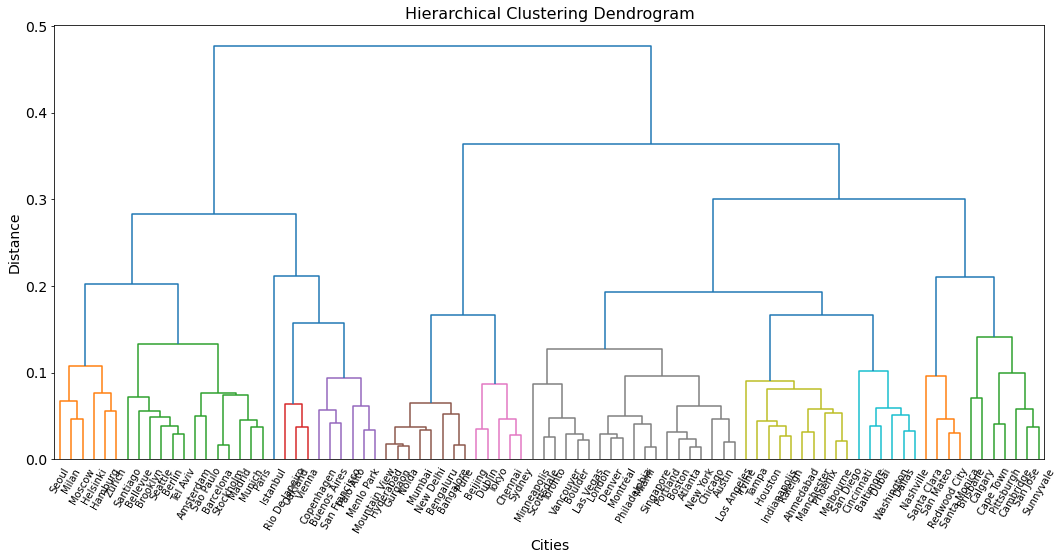

In [577]:
normalized_pivoted = filtered_pivoted.apply(lambda row: row / row.sum(), axis=1)

Z = linkage(normalized_pivoted, method='ward')

max_d = max(Z[:, 2])

threshold = 0.15

clusters = fcluster(Z, t=threshold, criterion='distance',)


plt.figure(figsize=(15, 8))

# Generate the dendrogram
dendro = dendrogram(Z, labels=normalized_pivoted.index,show_leaf_counts=True,color_threshold=threshold)

# Customize the tick label font size
plt.setp(plt.gca().get_xticklabels(), fontsize=10)
plt.setp(plt.gca().get_yticklabels(), fontsize=14)

plt.title("Hierarchical Clustering Dendrogram", fontsize=16)
plt.xlabel("Cities", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.xticks(rotation=60)  # Rotate x-axis labels if necessary

plt.tight_layout()
plt.show()

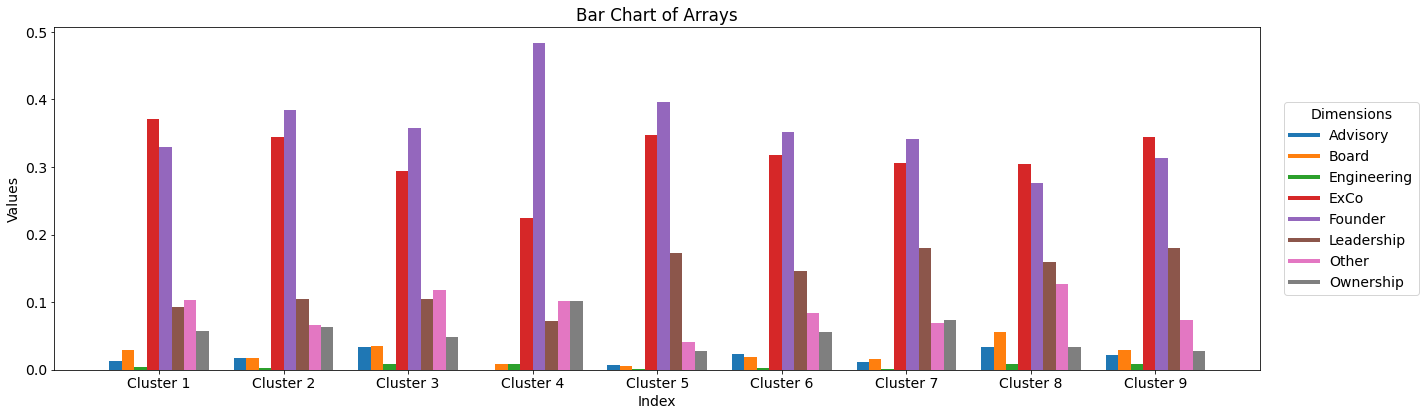

In [578]:
show_clusters(filtered_pivoted,
              dimension_labels,
              colors,
                  Z,
                  normalized=True, 
                  difference=False,
                  clusters = 9)       